### Imports

In [1]:
#Loading packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset, TensorDataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm 
import codecs
import random
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
%matplotlib inline

##### Ensuring reproducibility

In [2]:
#we fix the seeds to get consistent results
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#Fix GPU seeds
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

##### Loading the training data


In [3]:
train_data = pd.read_csv('dataset/offenseval-training-v1.tsv', sep="\t", header=0)
train_data.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


#### Data exploration

In [4]:
# Task A

# Extracting the training and the test set
X = train_data['tweet'].values
y_a = train_data['subtask_a'].values
y_b = train_data['subtask_b'].values
y_c = train_data['subtask_c'].values

# change labels for task A to binary labels. 
# 1 if post is offensive. 0 otherwise
y_a[y_a == 'OFF'] = 1
y_a[y_a == 'NOT'] = 0
y_a = y_a.astype(int)

X_a = X

# Extracting all examples which are relevant to task B
index_b_unt = y_b == 'UNT' 
index_b_tin = y_b == 'TIN' 

index_b = index_b_unt + index_b_tin
# The data
y_b = y_b[index_b]
X_b = X[index_b]

# Making the labels binary. 1 if post is targeted
# 0 if post is not targeted
y_b[y_b == 'TIN' ] = 1
y_b[y_b == 'UNT' ] = 0
y_b = y_b.astype(int)

# Creating the data for task C
index_c_grp = y_c == 'GRP'
index_c_ind = y_c == 'IND'
index_c_oth = y_c == 'OTH'

index_c = index_c_grp + index_c_ind + index_c_oth

y_c = y_c[index_c]
X_c = X[index_c]

# Making the labels binary. 0 if post is targeted
# at group, 1 if post is targeted at an idividual
# 2 if post is targeted at 'other'

y_c[y_c == 'GRP' ] = 0
y_c[y_c == 'IND' ] = 1
y_c[y_c == 'OTH' ] = 2
y_c = y_c.astype(int)

print('X_a shape: ', X_a.shape, ' y_a shape: ', y_a.shape)
print('X_b shape: ', X_b.shape, ' y_b shape: ', y_b.shape)
print('X_c shape: ', X_c.shape, ' y_c shape: ', y_c.shape)

X_a shape:  (13240,)  y_a shape:  (13240,)
X_b shape:  (4400,)  y_b shape:  (4400,)
X_c shape:  (3876,)  y_c shape:  (3876,)


In [5]:
# Creating Train and validation sets
val_size = 0.2

# Splitting the datasets for each task
X_a_train, X_a_val, y_a_train, y_a_val = train_test_split(X_a, y_a, test_size=val_size, random_state=SEED, shuffle=True)
X_b_train, X_b_val, y_b_train, y_b_val = train_test_split(X_b, y_b, test_size=val_size, random_state=SEED, shuffle=True)
X_c_train, X_c_val, y_c_train, y_c_val = train_test_split(X_c, y_c, test_size=val_size, random_state=SEED, shuffle=True)


In [6]:
# Loading the test sets
X_a_test = pd.read_csv('dataset/testset-taska.tsv', sep="\t", header=0)['tweet'].values
X_b_test = pd.read_csv('dataset/testset-taskb.tsv', sep="\t", header=0)['tweet'].values
X_c_test = pd.read_csv('dataset/test_set_taskc.tsv', sep="\t", header=0)['tweet'].values

print('X_a_test shape: ', X_a_test.shape)
print('X_b_test shape: ', X_b_test.shape)
print('X_c_test shape: ', X_c_test.shape)

X_a_test shape:  (860,)
X_b_test shape:  (240,)
X_c_test shape:  (213,)


In [7]:
# Checking for any class imbalance
unique_a, counts_a = np.unique(y_a_train, return_counts =True)
unique_b, counts_b = np.unique(y_b_train, return_counts =True)
unique_c, counts_c = np.unique(y_c_train, return_counts =True)

print('\nTask A: ', unique_a[0],': ', counts_a[0], ' ', unique_a[1], ': ', counts_a[1])
print('Task B: ', unique_b[0],': ', counts_b[0], ' ', unique_b[1], ': ', counts_b[1])
print('Task C: ', unique_c[0],': ', counts_c[0], ' ',
      unique_c[1], ': ', counts_c[1],' ', unique_c[2], ': ', counts_c[2], )


Task A:  0 :  7107   1 :  3485
Task B:  0 :  412   1 :  3108
Task C:  0 :  872   1 :  1906   2 :  322


Note: task A. Labels: 0 = not offensive, 1 = offensive
      task B. Labels: 0 = not targeted offense, 1 = targeted offense
      task C. Labels: 0 = targeted at group, 1 = targeted at individual, 2 = targeted at 'other'
        
        
As shown above, for all three tasks the classes are very unbalanced. Oversample minority classes.

In [8]:
# Over sampling to make to adress the class imbalance
rus = RandomOverSampler(random_state=0)

# Over sampling each training set
X_a_train, y_a_train = rus.fit_resample(X_a_train.reshape(-1, 1), y_a_train)
X_b_train, y_b_train = rus.fit_resample(X_b_train.reshape(-1, 1), y_b_train)
X_c_train, y_c_train = rus.fit_resample(X_c_train.reshape(-1, 1), y_c_train)

X_a_train = np.squeeze(X_a_train, 1)
X_b_train = np.squeeze(X_b_train, 1)
X_c_train = np.squeeze(X_c_train, 1)

# recounting number of examples from each class
unique_a, counts_a = np.unique(y_a_train, return_counts =True)
unique_b, counts_b = np.unique(y_b_train, return_counts =True)
unique_c, counts_c = np.unique(y_c_train, return_counts =True)

print('\nTask A: ', unique_a[0],': ', counts_a[0], ' ', unique_a[1], ': ', counts_a[1])
print('Task B: ', unique_b[0],': ', counts_b[0], ' ', unique_b[1], ': ', counts_b[1])
print('Task C: ', unique_c[0],': ', counts_c[0], ' ',
      unique_c[1], ': ', counts_c[1],' ', unique_c[2], ': ', counts_c[2], )


Task A:  0 :  7107   1 :  7107
Task B:  0 :  3108   1 :  3108
Task C:  0 :  1906   1 :  1906   2 :  1906


In [10]:
# Function to tokenize the sentense

def get_tokenize_sentence(sentence):
    
    # list to store a sentense
    tokenized_sentence = []
    
    # removing and ’
    sentence = sentence.replace("’", '')
    
    # Keeping # and !
    for token in re.findall(r"[\w']+|[# !]", sentence):
        
        # removing spaces from removed punctuation
        token = token.replace(' ', '')
        
        # only appending tokes which are not empty lists
        if len(token) > 0:
            tokenized_sentence.append(token.lower())
            
    return tokenized_sentence

In [11]:
# Function to tokenize a corpus

def get_tokenized_corpus(corpus):
    
    # list to store the corpus
    tokenized_corpus = []
    
    for sentence in corpus:
        tokenized_sentence = get_tokenize_sentence(sentence)
        tokenized_corpus.append(tokenized_sentence)
     
    return tokenized_corpus 

In [12]:
# Function to create a word to index dictionary
def get_word2idx(corpus):
    
    # get tokenized corpus
    tokenized_corpus = get_tokenized_corpus(corpus)
    
    # list to store vocabulary
    vocabulary = []
    
    for sentence in tokenized_corpus:
        
        for token in sentence:
            
            if token not in vocabulary:
                
                vocabulary.append(token)
    
    # creating a word to index dictionary
    word2idx = {w: idx+1 for (idx, w) in enumerate(vocabulary)}
    
    # we reserve the 0 index for the placeholder token
    word2idx['<pad>'] = 0
 
    return word2idx

In [13]:
# Function to create tensor inputs and lebels from a tokenized corpus

def get_model_inputs(tokenized_corpus, word2idx, labels, max_len):

    # we index our sentences
    vectorized_sents = [[word2idx[tok] for tok in sent if tok in word2idx] for sent in tokenized_corpus]
 
    # we create a tensor of a fixed size filled with zeroes for padding
    sent_tensor = Variable(torch.zeros((len(vectorized_sents), max_len))).long()  
    
    sent_lengths = [len(sent) for sent in vectorized_sents]
  
    # we fill it with our vectorized sentences 
    for idx, (sent, sentlen) in enumerate(zip(vectorized_sents, sent_lengths)):
        
        sent_tensor[idx, :sentlen] = torch.LongTensor(sent)
    
    label_tensor = torch.FloatTensor(labels)
  
    return sent_tensor, label_tensor

In [14]:
# Function to obtain the maximum tweet length

def max_sen_len(corpus):
    
    # get tokenized corpus
    tokenized_corpus = get_tokenized_corpus(corpus)
    
    # get length of each tweet
    sent_lengths = [len(sent) for sent in tokenized_corpus]
    
    # find maximum length
    max_len = np.max(np.array(sent_lengths))   
    
    return max_len

In [15]:
# Creating the word2idx dictionary and measuring the maximum sentence length
max_len = max_sen_len(X)
word2idx = get_word2idx(X)

print('Longest tweet in corpus has length ', max_len)

Longest tweet in corpus has length  105


In [16]:
# Function to get training and validation data loaders

BATCH_SIZE = 64

def getDataLoader(corpus, labels):
    
    # note max_len and word2idx must be predefined
    
    # get tokenized corpus
    tokenized_corpus = get_tokenized_corpus(corpus)
    
    # get tensor inputs
    tweets_tensor, labels_tensor = get_model_inputs(tokenized_corpus, word2idx, labels, max_len)
    
    # create a dataloader
    dataset = TensorDataset(tweets_tensor, labels_tensor)
    data_loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True)

    return data_loader

In [17]:
# Function to get a data loader without labels
 
def get_test_loader(corpus):
    
    # make fake labels to use get_model_inputs function
    labels = np.zeros(len(corpus))
    
    # tokenize the corpus
    tokenized_corpus = get_tokenized_corpus(corpus)
    
    # get tensor of inputs
    tweets_tensor, _  = get_model_inputs(tokenized_corpus, word2idx, labels, max_len)
    
    # create a data loader
    dataset = TensorDataset(tweets_tensor)
    data_loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True)

    return data_loader

In [18]:
# Data loader for training, validation and test
train_loader_a = getDataLoader(X_a_train, y_a_train)
val_loader_a   = getDataLoader(X_a_val, y_a_val)
test_loader_a  = get_test_loader(X_a_test)

train_loader_b = getDataLoader(X_b_train, y_b_train)
val_loader_b   = getDataLoader(X_b_val, y_b_val)
test_loader_b  = get_test_loader(X_b_test)

train_loader_c = getDataLoader(X_c_train, y_c_train)
val_loader_c   = getDataLoader(X_c_val, y_c_val)
test_loader_c  = get_test_loader(X_c_test)

# Helper functions

In [19]:
# Function to get the f1 score

def f_measure(output, gold):
    
    output = output >= 0.5
    output = output.cpu().numpy()
    gold = gold.cpu().numpy()

    recall, precision, fscore, _ = precision_recall_fscore_support(output, gold, average='weighted')
    
    return recall, precision, fscore

In [23]:
# Function to get the recall, precision and f score for multiclass problems

def f_measure_c(output, gold):

    output = torch.argmax(output, dim = 1)
    output = output.cpu().numpy()
    gold = gold.cpu().numpy()

    recall, precision, fscore, _ = precision_recall_fscore_support(output, gold, labels=[0, 1, 2])
    recall_m, precision_m, fscore_m, _ = precision_recall_fscore_support(output, gold, labels=[0, 1, 2], average='macro')
    
    return np.append(recall, recall_m), np.append(precision, precision_m), np.append(fscore, fscore_m)

In [20]:
# Function to get the accuracy

def accuracy(output, target):
    
    correct = torch.sum((output >= 0.5).float() == target.float(), dtype = torch.float)
    acc = correct.item() / len(target)
 
    return acc

In [21]:
# Function to get the accuracy for multiclass problems

def get_accuracy_softmax(output, target):
    
    pred = torch.argmax(output, dim = 1)
    acc = (pred == target).sum().item() / len(pred)
 
    return acc

In [22]:
# Function to initialize the weights of a network

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)
    if type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)

# Creating and training the model

In [24]:
# Function to trian a network

def train_model(model, train_loader, valid_loader,activation = 'sigmoid' ,alpha = 0., epochs = 20):  
    
    # Lists to store different quantities of interest
    training_loss = []
    training_acc = []
    
    validation_loss = []
    validation_acc = []
    
    validation_recall = []
    validation_precision = []
    validation_f1 = []
    
    for epoch in range(1, epochs+1):
        
        # during each epoch setting quantities to 0
        recall = 0
        precision = 0
        fscore = 0

        epoch_loss = 0
        epoch_acc = 0
        
        valid_loss = 0
        valid_acc = 0
        
        model.train()
       
        #iterate over batches
        for feature, target in train_loader:
            
            #place on the GPU
            feature = feature.to(device)
            
            # Convert target to tensor if multiclass problem
            if activation == 'softmax':
                target = target.type(torch.LongTensor)
                
            # place target on gpu
            target = target.to(device)
            
            # set gradient of optimizer to 0
            optimizer.zero_grad()
            
            # get predictions
            predictions = model(feature)
            
            # apply output activation function
            if activation == 'sigmoid':
                predictions = torch.sigmoid(predictions)
            elif activation == 'softmax':
                predictions = F.softmax(predictions, dim = 1)
            
            # calculate the loss
            loss = loss_fn(predictions, target) + alpha * model.l2_weight_penalty()
            
            # getting the accuracy
            if activation == 'sigmoid':
                acc = accuracy(predictions, target)
            elif activation == 'softmax':
                acc = get_accuracy_softmax(predictions, target)
            
            # backpropagation
            loss.backward()
            optimizer.step()
            
            # appending the loss and accuracy from batch
            epoch_loss += loss.item()
            epoch_acc += acc
        
        # testing model on validation set
        with torch.no_grad():
            
            # loop over all batches
            for feature_valid, target_valid in valid_loader:
                
                # place input on gpu
                feature_valid = feature_valid.to(device)
                
                # convert to long tensor if multiclass classification problem
                if activation == 'softmax':
                    target_valid = target_valid.type(torch.LongTensor)
                    
                # place target on gpu
                target_valid = target_valid.to(device)
                
                # get predictions
                predictions_valid = model(feature_valid)
                
                # apply output activation function
                if activation == 'sigmoid':
                    predictions_valid = torch.sigmoid(predictions_valid)
                elif activation == 'softmax':
                    predictions_valid = F.softmax(predictions_valid, dim = 1)

                # get loss
                loss = loss_fn(predictions_valid, target_valid) + alpha * model.l2_weight_penalty()
                
                # get accuracy
                if activation == 'sigmoid':
                    acc = accuracy(predictions_valid, target_valid)
                elif activation == 'softmax':
                    acc = get_accuracy_softmax(predictions_valid, target_valid)
                
                # append relevant quantities every batch
                valid_loss += loss.item()
                valid_acc += acc
                
                if activation == 'sigmoid':
                    r, p, f = f_measure(predictions_valid, target_valid)
                    recall += r
                    precision += p
                    fscore += f
                elif activation == 'softmax':
                    r, p, f = f_measure_c(predictions_valid, target_valid)
                    recall += r[1]
                    precision += p[1]
                    fscore += f[1]
               
        # get averages so that quantaties are mean per batch
        epoch_loss /=  len(train_loader)
        epoch_acc /=  len(train_loader)
        
        valid_loss /= len(valid_loader)
        valid_acc /= len(valid_loader)
        
        recall /= len(valid_loader)
        precision /= len(valid_loader)
        fscore /= len(valid_loader)
        
        training_loss.append(epoch_loss)
        training_acc.append(epoch_acc)

        validation_loss.append(valid_loss)
        validation_acc.append(valid_acc)
        validation_recall.append(recall)
        validation_precision.append(precision)
        validation_f1.append(fscore)
        
        # print relevant information
        print(f'| Epoch: {epoch:02}| Train Acc: {epoch_acc*100:.2f}% | Val. Acc: {valid_acc*100:.2f}% | Recall: {recall:.2f} | Precision: {precision:.2f} | f score: {fscore:.2f}')
        
        # implement early stopping
        if len(validation_loss) > 3 and validation_loss[epoch - 1] > validation_loss[epoch - 4]:
            break
            
    return training_loss, training_acc, validation_loss, validation_acc, validation_recall, validation_precision, validation_f1

In [30]:
# The main model.

class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, out_channels):
        
        super(MyModel, self).__init__()
        
        # Both are for the gated recurrent unit
        self.n_hidden = 5
        self.input_size = 8
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # convolution at three different scales: 1 gram, 3 gram and 5 gram
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.input_size, kernel_size=(1,embedding_dim))
        self.conv3 = nn.Conv2d(in_channels=1, out_channels=self.input_size, kernel_size=(3,embedding_dim))
        self.conv5 = nn.Conv2d(in_channels=1, out_channels=self.input_size, kernel_size=(5,embedding_dim))
        
        # gated recurrent units for all three scales
        self.gru1 = nn.GRU(self.input_size, self.n_hidden)
        self.gru3 = nn.GRU(self.input_size, self.n_hidden)
        self.gru5 = nn.GRU(self.input_size, self.n_hidden)
        
        # pooling to downsample before fully connected layer
        self.pool = nn.AvgPool1d(8, 8)

        # fully connected layer to combine outputs from GRU's
        self.fc = nn.Sequential(
            nn.Linear(193, out_channels)
            )
        

            
    def forward(self, x):
        batch_size, _ = x.shape
        
        # get embedding
        embedded = self.embedding(x)
                
        #(batch size, max sent length, embedding dim)
        #for the text we add 1 channel
        embedded = embedded.unsqueeze(1)

        #(batch size, 1, max sent length, embedding dim)
        
        
        # first branch of the model

        
        f1 = self.conv1(embedded)
        
        #(batch size, out_channels, max sent length - window_size + 1, 1)
        
        f1 = f1.squeeze(3)
        f1 = F.relu(f1)
        #(batch size, out_channels, max sent length - window_size + 1)
        
        f1 = torch.transpose(torch.transpose(f1, 1, 2), 0, 1)
        
        #(max sent length - window_size + 1, batch size, out_channels)
        
        self.h1 = self.init_hidden(batch_size)
        gru_out1, self.h1 = self.gru1(f1, self.h1)        
        gru_out1 = torch.transpose(gru_out1, 0, 1)
        gru_out1 = gru_out1.contiguous().view(gru_out1.shape[0], -1)

        
        # second branch of the model
        
        
        f3 = self.conv3(embedded)
        
        #(batch size, out_channels, max sent length - window_size + 1, 1)
        f3 = f3.squeeze(3)
        f3 = F.relu(f3)
        
        #(batch size, out_channels, max sent length - window_size + 1)
        f3 = torch.transpose(torch.transpose(f3, 1, 2), 0, 1)
        
        #(max sent length - window_size + 1, batch size, out_channels)
        self.h3 = self.init_hidden(batch_size)
        gru_out3, self.h3 = self.gru3(f3, self.h3)
        gru_out3 = torch.transpose(gru_out3, 0, 1)
        gru_out3 = gru_out3.contiguous().view(gru_out3.shape[0], -1)

        
        # third branch of the model
        
        f5 = self.conv5(embedded)
        
        #(batch size, out_channels, max sent length - window_size + 1, 1)
        f5 = f5.squeeze(3)
        f5 = F.relu(f5)
        
        #(batch size, out_channels, max sent length - window_size + 1)
        f5 = torch.transpose(torch.transpose(f5, 1, 2), 0, 1)
        
        #(max sent length - window_size + 1, batch size, out_channels)
        self.h5 = self.init_hidden(batch_size)
        gru_out5, self.h5 = self.gru5(f5, self.h5)
        gru_out5 = torch.transpose(gru_out5, 0, 1)
        gru_out5 = gru_out5.contiguous().view(gru_out5.shape[0], -1)
   

        # combining the three branches
    
    
        c = torch.cat((gru_out1, gru_out3), dim = 1)
        c = torch.cat((c, gru_out5), dim = 1)
        c = c.unsqueeze(1)
        
        # pooling
        
        c = self.pool(c)
        c = c.squeeze(1)
        
        # getting the final prediction
        
        preds = self.fc(c)
        
        return preds.squeeze(-1)
    
    def l2_weight_penalty(self):
        """
        Computes and returns the L2 weight penalty (i.e. 
        sum of squared values of all model parameters).
        """
        l2 = 0.
        for parameter in self.parameters():
            l2 += (parameter*parameter).sum()
        return l2
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros((1,batch_size,self.n_hidden))).to('cuda')

In [32]:
# Trainig the main model on task A
vocab_size = len(word2idx)
embedding_dim = 50
out_dim = 1
output_channels = 64

# Setting the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# random seed
torch.manual_seed(2)

#creating a model and initializing weights
model_a  = MyModel(vocab_size, embedding_dim,1)
model_a.apply(init_weights)
model_a = model_a.to(device)

# creating an optimizer and loss function
optimizer = optim.Adam(model_a.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

# training the model
training_loss, training_acc, validation_loss, validation_acc, validation_recall, validation_precision, validation_f1 = train_model(model_a,
                                                                                                        train_loader_a,
                                                                                                        val_loader_a,
                                                                                                        alpha = 1e-3,
                                                                                                        activation = 'sigmoid',
                                                                                                        epochs = 24)

| Epoch: 01| Train Acc: 54.39% | Val. Acc: 58.33% | Recall: 0.59 | Precision: 0.58 | f score: 0.58
| Epoch: 02| Train Acc: 57.21% | Val. Acc: 58.47% | Recall: 0.59 | Precision: 0.58 | f score: 0.58
| Epoch: 03| Train Acc: 59.74% | Val. Acc: 56.65% | Recall: 0.60 | Precision: 0.57 | f score: 0.56
| Epoch: 04| Train Acc: 62.04% | Val. Acc: 62.17% | Recall: 0.62 | Precision: 0.62 | f score: 0.62
| Epoch: 05| Train Acc: 64.39% | Val. Acc: 60.96% | Recall: 0.64 | Precision: 0.61 | f score: 0.60
| Epoch: 06| Train Acc: 67.68% | Val. Acc: 61.48% | Recall: 0.63 | Precision: 0.61 | f score: 0.60
| Epoch: 07| Train Acc: 70.44% | Val. Acc: 69.01% | Recall: 0.70 | Precision: 0.69 | f score: 0.69
| Epoch: 08| Train Acc: 73.91% | Val. Acc: 67.30% | Recall: 0.68 | Precision: 0.67 | f score: 0.67
| Epoch: 09| Train Acc: 77.99% | Val. Acc: 70.29% | Recall: 0.71 | Precision: 0.70 | f score: 0.70
| Epoch: 10| Train Acc: 81.39% | Val. Acc: 73.14% | Recall: 0.81 | Precision: 0.73 | f score: 0.75
| Epoch: 1

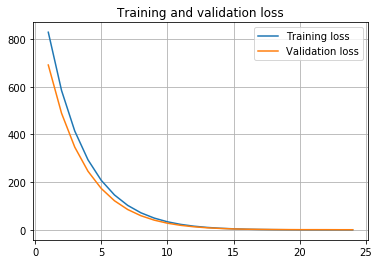

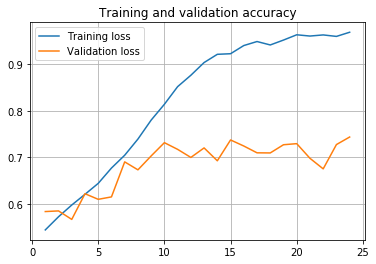

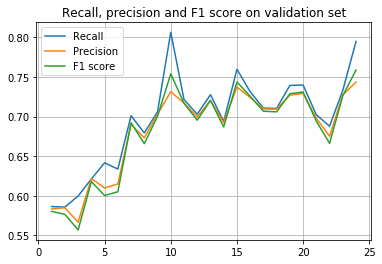

In [33]:
plt.figure('Training and validation loss')
plt.title('Training and validation loss')
plt.plot([i for i in range(1, len(training_loss) + 1)], training_loss, label = 'Training loss')
plt.plot([i for i in range(1, len(validation_loss) + 1)], validation_loss, label = 'Validation loss')
plt.grid()
plt.legend()

plt.figure('Training and validation accuracy')
plt.title('Training and validation accuracy')
plt.plot([i for i in range(1, len(training_acc) + 1)], training_acc, label = 'Training loss')
plt.plot([i for i in range(1, len(validation_acc) + 1)], validation_acc, label = 'Validation loss')
plt.grid()
plt.legend()

plt.figure('Recall, precision and F1 score on validation set')
plt.title('Recall, precision and F1 score on validation set')
plt.plot([i for i in range(1, len(validation_recall) + 1)], validation_recall, label = 'Recall')
plt.plot([i for i in range(1, len(validation_precision) + 1)], validation_precision, label = 'Precision')
plt.plot([i for i in range(1, len(validation_f1) + 1)], validation_f1, label = 'F1 score')
plt.grid()
plt.legend()
plt.show()

In [34]:
#Training the main model on task B

vocab_size = len(word2idx)
embedding_dim = 50
out_dim = 1
output_channels = 64

# Setting the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# random seed
torch.manual_seed(42)

# creating the model
model_b  = MyModel(vocab_size, embedding_dim, 1) 
model_b.apply(init_weights)
model_b = model_b.to(device)

# creating optimizer and loss function
optimizer = optim.Adam(model_b.parameters(), lr=5e-4)
loss_fn = nn.BCELoss()

# training the model
training_loss, training_acc, validation_loss, validation_acc, validation_recall, validation_precision, validation_f1 = train_model(
                                                                                                        model_b,
                                                                                                        train_loader_b,
                                                                                                        val_loader_b,
                                                                                                        activation = 'sigmoid',
                                                                                                        alpha = 1e-5,
                                                                                                        epochs = 21)

| Epoch: 01| Train Acc: 57.30% | Val. Acc: 59.34% | Recall: 0.60 | Precision: 0.59 | f score: 0.53
| Epoch: 02| Train Acc: 60.49% | Val. Acc: 64.62% | Recall: 0.63 | Precision: 0.65 | f score: 0.59
| Epoch: 03| Train Acc: 61.61% | Val. Acc: 62.39% | Recall: 0.60 | Precision: 0.62 | f score: 0.56
| Epoch: 04| Train Acc: 62.88% | Val. Acc: 66.00% | Recall: 0.61 | Precision: 0.66 | f score: 0.61
| Epoch: 05| Train Acc: 68.11% | Val. Acc: 64.14% | Recall: 0.59 | Precision: 0.64 | f score: 0.58
| Epoch: 06| Train Acc: 74.70% | Val. Acc: 68.60% | Recall: 0.64 | Precision: 0.69 | f score: 0.64
| Epoch: 07| Train Acc: 81.06% | Val. Acc: 73.25% | Recall: 0.70 | Precision: 0.73 | f score: 0.70
| Epoch: 08| Train Acc: 86.24% | Val. Acc: 72.95% | Recall: 0.68 | Precision: 0.73 | f score: 0.70
| Epoch: 09| Train Acc: 90.05% | Val. Acc: 72.58% | Recall: 0.69 | Precision: 0.73 | f score: 0.69
| Epoch: 10| Train Acc: 93.16% | Val. Acc: 77.12% | Recall: 0.75 | Precision: 0.77 | f score: 0.76
| Epoch: 1

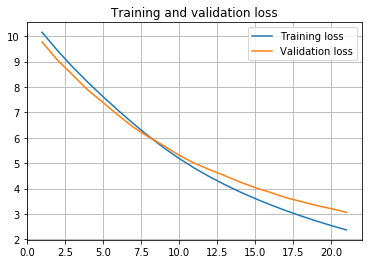

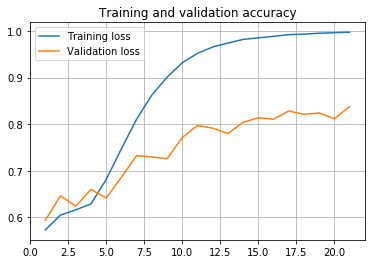

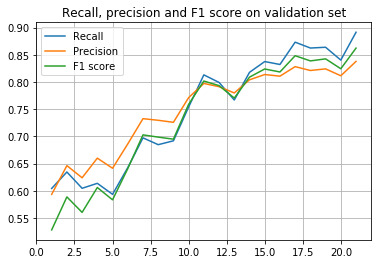

In [35]:
plt.figure('Training and validation loss')
plt.title('Training and validation loss')
plt.plot([i for i in range(1, len(training_loss) + 1)], training_loss, label = 'Training loss')
plt.plot([i for i in range(1, len(validation_loss) + 1)], validation_loss, label = 'Validation loss')
plt.grid()
plt.legend()

plt.figure('Training and validation accuracy')
plt.title('Training and validation accuracy')
plt.plot([i for i in range(1, len(training_acc) + 1)], training_acc, label = 'Training loss')
plt.plot([i for i in range(1, len(validation_acc) + 1)], validation_acc, label = 'Validation loss')
plt.grid()
plt.legend()

plt.figure('Recall, precision and F1 score on validation set')
plt.title('Recall, precision and F1 score on validation set')
plt.plot([i for i in range(1, len(validation_recall) + 1)], validation_recall, label = 'Recall')
plt.plot([i for i in range(1, len(validation_precision) + 1)], validation_precision, label = 'Precision')
plt.plot([i for i in range(1, len(validation_f1) + 1)], validation_f1, label = 'F1 score')
plt.grid()
plt.legend()
plt.show()

In [36]:
#Training model on task C
vocab_size = len(word2idx)
embedding_dim = 100
out_dim = 1
output_channels = 64

# Setting the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# random seed
torch.manual_seed(42)

# creating the model
model_c  = MyModel(vocab_size, embedding_dim, 3) 
model_c.apply(init_weights)
model_c = model_c.to(device)

# creating the optimizer and loss function
optimizer = optim.Adam(model_c.parameters(), lr=8e-4)
loss_fn = nn.CrossEntropyLoss()

# Training the model
training_loss, training_acc, validation_loss, validation_acc, validation_recall, validation_precision, validation_f1 = train_model(model_c,
                                                                                                        train_loader_c,
                                                                                                        val_loader_c,
                                                                                                        activation = 'softmax',
                                                                                                        alpha = 1e-3,
                                                                                                        epochs = 26)

C:\Users\kamil\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


| Epoch: 01| Train Acc: 38.75% | Val. Acc: 27.16% | Recall: 0.24 | Precision: 0.75 | f score: 0.36
| Epoch: 02| Train Acc: 42.12% | Val. Acc: 54.57% | Recall: 0.61 | Precision: 0.76 | f score: 0.67
| Epoch: 03| Train Acc: 50.57% | Val. Acc: 56.61% | Recall: 0.66 | Precision: 0.79 | f score: 0.71
| Epoch: 04| Train Acc: 59.22% | Val. Acc: 56.01% | Recall: 0.64 | Precision: 0.83 | f score: 0.72
| Epoch: 05| Train Acc: 66.14% | Val. Acc: 54.69% | Recall: 0.59 | Precision: 0.84 | f score: 0.69
| Epoch: 06| Train Acc: 73.40% | Val. Acc: 57.45% | Recall: 0.61 | Precision: 0.81 | f score: 0.70
| Epoch: 07| Train Acc: 79.92% | Val. Acc: 61.90% | Recall: 0.68 | Precision: 0.82 | f score: 0.74


C:\Users\kamil\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


| Epoch: 08| Train Acc: 83.08% | Val. Acc: 61.42% | Recall: 0.71 | Precision: 0.78 | f score: 0.74
| Epoch: 09| Train Acc: 85.01% | Val. Acc: 61.30% | Recall: 0.70 | Precision: 0.81 | f score: 0.74
| Epoch: 10| Train Acc: 86.19% | Val. Acc: 61.42% | Recall: 0.69 | Precision: 0.78 | f score: 0.73
| Epoch: 11| Train Acc: 87.31% | Val. Acc: 61.90% | Recall: 0.72 | Precision: 0.79 | f score: 0.75
| Epoch: 12| Train Acc: 88.25% | Val. Acc: 63.58% | Recall: 0.72 | Precision: 0.79 | f score: 0.75
| Epoch: 13| Train Acc: 88.28% | Val. Acc: 62.74% | Recall: 0.72 | Precision: 0.80 | f score: 0.76
| Epoch: 14| Train Acc: 89.22% | Val. Acc: 62.86% | Recall: 0.73 | Precision: 0.77 | f score: 0.75
| Epoch: 15| Train Acc: 88.46% | Val. Acc: 63.10% | Recall: 0.71 | Precision: 0.79 | f score: 0.75
| Epoch: 16| Train Acc: 89.50% | Val. Acc: 62.98% | Recall: 0.75 | Precision: 0.78 | f score: 0.76
| Epoch: 17| Train Acc: 89.40% | Val. Acc: 60.94% | Recall: 0.69 | Precision: 0.80 | f score: 0.74
| Epoch: 1

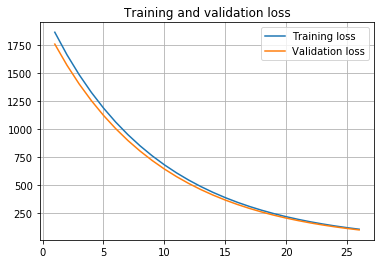

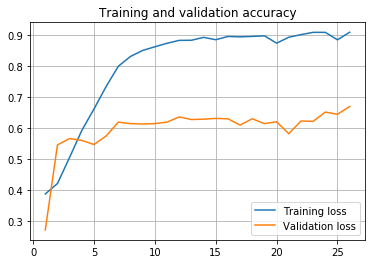

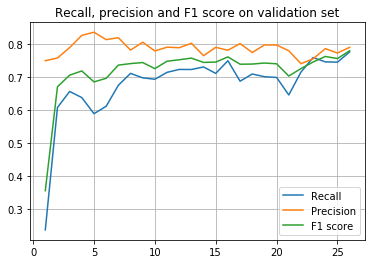

In [37]:
plt.figure('Training and validation loss')
plt.title('Training and validation loss')
plt.plot([i for i in range(1, len(training_loss) + 1)], training_loss, label = 'Training loss')
plt.plot([i for i in range(1, len(validation_loss) + 1)], validation_loss, label = 'Validation loss')
plt.grid()
plt.legend()

plt.figure('Training and validation accuracy')
plt.title('Training and validation accuracy')
plt.plot([i for i in range(1, len(training_acc) + 1)], training_acc, label = 'Training loss')
plt.plot([i for i in range(1, len(validation_acc) + 1)], validation_acc, label = 'Validation loss')
plt.grid()
plt.legend()

plt.figure('Recall, precision and F1 score on validation set')
plt.title('Recall, precision and F1 score on validation set')
plt.plot([i for i in range(1, len(validation_recall) + 1)], validation_recall, label = 'Recall')
plt.plot([i for i in range(1, len(validation_precision) + 1)], validation_precision, label = 'Precision')
plt.plot([i for i in range(1, len(validation_f1) + 1)], validation_f1, label = 'F1 score')
plt.grid()
plt.legend()
plt.show()

# Getting challenge predictions

In [61]:
# For test set for submission
def getEvaTensor(test_data, word2idx, max_len):
    place_hold = torch.empty((1,1))
    tokenized_corpus = get_tokenized_corpus(test_data)
    test_sent_tensor, _ = get_model_inputs(tokenized_corpus, word2idx, place_hold, max_len)
    
    return test_sent_tensor

In [62]:
# For test set for submission
eva_data_a = getEvaTensor(np.array(pd.read_csv('dataset/testset-taska.tsv', sep="\t", header=0).astype(str))[:, 1], word2idx, max_len)
eva_data_b = getEvaTensor(np.array(pd.read_csv('dataset/testset-taskb.tsv', sep="\t", header=0).astype(str))[:, 1], word2idx, max_len)
eva_data_c = getEvaTensor(np.array(pd.read_csv('dataset/test_set_taskc.tsv', sep="\t", header=0).astype(str))[:, 1], word2idx, max_len)

eva_id_a = np.array(pd.read_csv('dataset/testset-taska.tsv', sep="\t", header=0).astype(str))[:, 0]
eva_id_b = np.array(pd.read_csv('dataset/testset-taskb.tsv', sep="\t", header=0).astype(str))[:, 0]
eva_id_c = np.array(pd.read_csv('dataset/test_set_taskc.tsv', sep="\t", header=0).astype(str))[:, 0]

print('eva_data_a shape: ', eva_data_a.shape)
print('eva_data_b shape: ', eva_data_b.shape)
print('eva_data_c shape: ', eva_data_c.shape)

print('eva id a shape: ', eva_id_a.shape)
print('eva id b shape: ', eva_id_b.shape)
print('eva id c shape: ', eva_id_c.shape)

eva_data_a shape:  torch.Size([860, 105])
eva_data_b shape:  torch.Size([240, 105])
eva_data_c shape:  torch.Size([213, 105])
eva id a shape:  (860,)
eva id b shape:  (240,)
eva id c shape:  (213,)


In [63]:
# Get predictions of test data for submission
predictions_eva_a = []
predictions_eva_b = []
predictions_eva_c = []

model_a.eval()
model_b.eval()
model_c.eval()

with torch.no_grad():
    
    feature_eva_a = eva_data_a.to('cuda')
    predictions_eva_a.append(model_a(feature_eva_a))
    
    feature_eva_b = eva_data_b.to('cuda')
    predictions_eva_b.append(model_b(feature_eva_b))
    
    feature_eva_c = eva_data_c.to('cuda')
    predictions_eva_c.append(model_c(feature_eva_c))

In [64]:
predict_results_a = predictions_eva_a[0].cpu().numpy().flatten()
predict_results_b = predictions_eva_b[0].cpu().numpy().flatten()
predict_results_c = predictions_eva_c[0].cpu().numpy()

In [65]:
# Assign labels and write csv
predict_label_a = np.empty(len(predict_results_a), dtype = object)

predict_label_a[predict_results_a < 0.5] = "NOT"
predict_label_a[predict_results_a >= 0.5] = "OFF"

df_a = pd.DataFrame({'Id':eva_id_a, 'Label':predict_label_a})
df_a.to_csv('task_a_results.csv', index=False, header = False)

predict_label_b = np.empty(len(predict_results_b), dtype = object)

predict_label_b[predict_results_b < 0.5] = "TIN"
predict_label_b[predict_results_b >= 0.5] = "UNT"

df_b = pd.DataFrame({'Id':eva_id_b, 'Label':predict_label_b})
df_b.to_csv('task_b_results.csv', index=False, header = False)


In [66]:
predict_label_c = np.empty(len(predict_results_c), dtype = object)

predict_label_c[np.argmax(predict_results_c, axis = 1) == 0] = "GRP"
predict_label_c[np.argmax(predict_results_c, axis = 1) == 1] = "IND"
predict_label_c[np.argmax(predict_results_c, axis = 1) == 2] = "OTH"

df_c = pd.DataFrame({'Id':eva_id_c, 'Label':predict_label_c})
df_c.to_csv('task_c_results.csv', index=False, header = False)


# Experimental designs

In [19]:
# Initial network model. Did not perform as well. convolutional with fully connected layer
class Network(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_channels):
        super(Network, self).__init__()

        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # 2 gram
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, output_channels, kernel_size=(2,embedding_dim)),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(True),
            nn.Conv2d(output_channels, 1, kernel_size = 1),
            nn.BatchNorm2d(1),
            nn.ReLU(True))
        
        
        # 3 gram
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, output_channels, kernel_size=(3,embedding_dim)),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(True),
            nn.Conv2d(output_channels, 1, kernel_size = 1),
            nn.BatchNorm2d(1),
            nn.ReLU(True))
        
        # 5 gram
        self.conv3 = nn.Sequential(
            nn.Conv2d(1, output_channels, kernel_size=(5,embedding_dim)),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(True),
            nn.Conv2d(output_channels, 1, kernel_size = 1),
            nn.BatchNorm2d(1),
            nn.ReLU(True))
        

        self.fc = nn.Sequential(
            nn.Linear(308, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 1),
            nn.Sigmoid()
            )
        
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.unsqueeze(1)
            
        self.gram2 = self.conv1(embedded)
        # Removing unwanted dimensions
        self.gram2 = self.gram2.squeeze(1)
        self.gram2 = self.gram2.squeeze(-1)
        
        self.gram3 = self.conv2(embedded)
        # Removing unwanted dimensions
        self.gram3 = self.gram3.squeeze(1)
        self.gram3 = self.gram3.squeeze(-1)
        
        self.gram5 = self.conv3(embedded)
        # Removing unwanted dimensions
        self.gram5 = self.gram5.squeeze(1)
        self.gram5 = self.gram5.squeeze(-1)
        
        inputs = torch.cat((self.gram2, self.gram3), dim = 1)
        inputs = torch.cat((inputs, self.gram5), dim = 1)
            
        output = self.fc(inputs)
        return output.squeeze(-1)


In [20]:
# Fully convolutional model. Did not perform as well.

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_channels):
        super(CNN, self).__init__()

        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # 2 gram
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, output_channels, kernel_size=(2,embedding_dim)),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(True),
            nn.Conv2d(output_channels, output_channels, kernel_size=(3,1)),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(True),
            nn.Conv2d(output_channels, output_channels, kernel_size=(5,1)),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(True),
            nn.Conv2d(output_channels, output_channels, kernel_size=(3,1), stride = 2),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(True),
            nn.Conv2d(output_channels, output_channels, kernel_size=(3,1), stride = 2),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(True),
            nn.Conv2d(output_channels, output_channels, kernel_size=(3,1), stride = 2),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(True),
            nn.Conv2d(output_channels, output_channels, kernel_size=(3,1), stride = 2),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(True),
            nn.Conv2d(output_channels, output_channels, kernel_size=(3,1), stride = 2),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(True),
            nn.Conv2d(output_channels, 1, kernel_size=(2,1)),
            nn.Sigmoid()
            )
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.unsqueeze(1)
        
        conv1 = self.conv1(embedded)
        conv1 = conv1.squeeze(-1)
        conv1 = conv1.squeeze(-1)
        conv1 = conv1.squeeze(-1)
        
        return conv1
